# 1.5. Normalisation

Normalisation is an important concept in both computational modelling and biological neural networks.
The underlying idea is intuitive: adjusting values to a common scale or standard.

In the figure below, we can observe that before normalisation, the set of points are scattered throughout the space. After normalisation, however, they become centred around zero with a unit variance.
Processing normalised data is numerically easier and generally leads to faster and more stable learning compared to working with unnormalised data.

<img src="https://raw.githubusercontent.com/DeepLearning-JupyterBook/deeplearning-jupyterbook.github.io/refs/heads/master/imgs/normalisation.png" width="400" height="400" />

Normalisation is also a common mechanism in **biological neural networks**.
A notable example is **Divisive Normalization**, observed in the human brain and described in the seminal article [*Normalization as a canonical neural computation*](https://www.nature.com/articles/nrn3136) by Matteo Carandini and David J. Heeger.

Inspired by such biological processes, the **Local Response Normalization (LRN)** mechanism was introduced in early convolutional neural networks such as *AlexNet*.
LRN normalises the activity of a single neuron by considering the activity of its neighbouring neurons, similar to the process of *lateral inhibition* in biological systems.
However, LRN is rarely used in modern architectures, having been largely replaced by **Batch Normalization (BN)**.

## Batch Normalization

**Batch Normalization**, proposed by [Ioffe & Szegedy (2015)](https://arxiv.org/abs/1502.03167), is a layer that normalises the activations of a neural network across the batch dimension.
It stabilises and accelerates training by keeping activations within a consistent range.

In simple terms, Batch Normalization:

1. Computes the **mean** (μ) and **standard deviation** (σ) for each feature across the batch.
2. Normalises each feature:
   $
   \hat{x} = \frac{x - \mu}{\sigma}
   $
3. Optionally applies a **learnable scaling** (γ) and **shifting** (β):
   $
   y = \gamma \hat{x} + \beta
   $

Batch Normalization is a ubiquitous operation in modern deep learning architectures, including **ResNets** and **Transformers**.
By reducing the **internal covariate shift**, it:

* Smooths optimisation, allowing the use of higher learning rates.
* Reduces sensitivity to initialisation.
* Acts as a regulariser (sometimes reducing the need for dropout).

## 0. Preparation

To demonstrate how **Batch Normalization** transforms a set of input data.
We will:

1. Generate a set of random 2D samples.
2. Visualise the unnormalised data.
3. Apply batch normalization (batch size = 8).
4. Visualise the normalised data.

The goal is to see how Batch Normalization rescales and recentres the data distribution.

In [1]:
# importing the necessary packages/libraries
import matplotlib.pyplot as plt
import torch

## 1. Generate random data

In [2]:
torch.manual_seed(0)
X = torch.randn(128, 2) * torch.tensor([4.0, 1.0]) + torch.tensor([10.0, -5.0])

print("Original data shape:", X.shape)
print("Feature means before normalization:", X.mean(dim=0))
print("Feature stds before normalization:", X.std(dim=0))

Original data shape: torch.Size([128, 2])
Feature means before normalization: tensor([10.1462, -4.9851])
Feature stds before normalization: tensor([3.5737, 0.9892])


## 2. Visualise the unnormalised data.

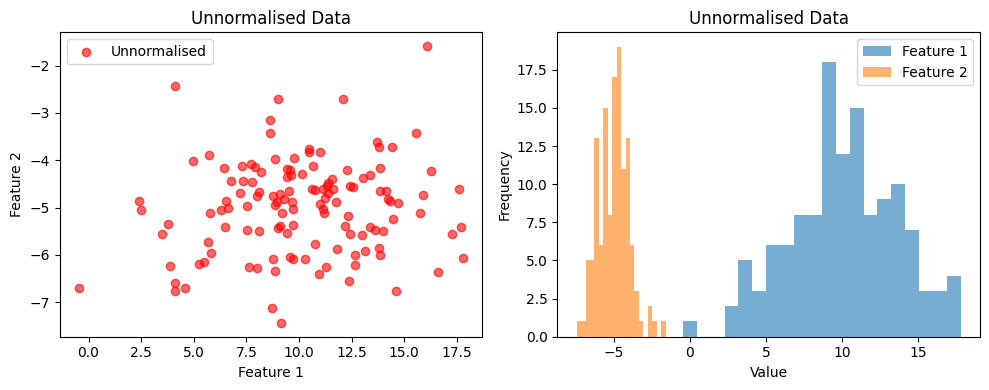

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot of unnormalised data
axs[0].scatter(X[:, 0], X[:, 1], c='red', alpha=0.6, label='Unnormalised')
axs[0].set_title('Unnormalised Data')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].legend()

# Histogram of each feature
axs[1].hist(X[:, 0].numpy(), bins=20, alpha=0.6, label='Feature 1')
axs[1].hist(X[:, 1].numpy(), bins=20, alpha=0.6, label='Feature 2')
axs[1].set_title('Unnormalised Data')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.tight_layout()
plt.show()

## 3. Apply batch normalization

We now apply **Batch Normalization** to our data.
Batch Normalization is typically applied **per batch** in neural networks, so here we simulate that by splitting our dataset into batches of size 8 and applying a `torch.nn.BatchNorm1d` layer.

In [4]:
bn = torch.nn.BatchNorm1d(num_features=2, affine=True, track_running_stats=False)

batch_size = 8
X_bn = []

for i in range(0, len(X), batch_size):
    batch = X[i:i+batch_size]
    normed = bn(batch)
    X_bn.append(normed)

X_bn = torch.cat(X_bn, dim=0)

print("Feature means after normalisation:", X_bn.mean(dim=0))
print("Feature stds after normalisation:", X_bn.std(dim=0))

Feature means after normalisation: tensor([ 5.2154e-08, -3.7253e-08], grad_fn=<MeanBackward1>)
Feature stds after normalisation: tensor([1.0039, 1.0039], grad_fn=<StdBackward0>)


## 4. Visualise the normalised data

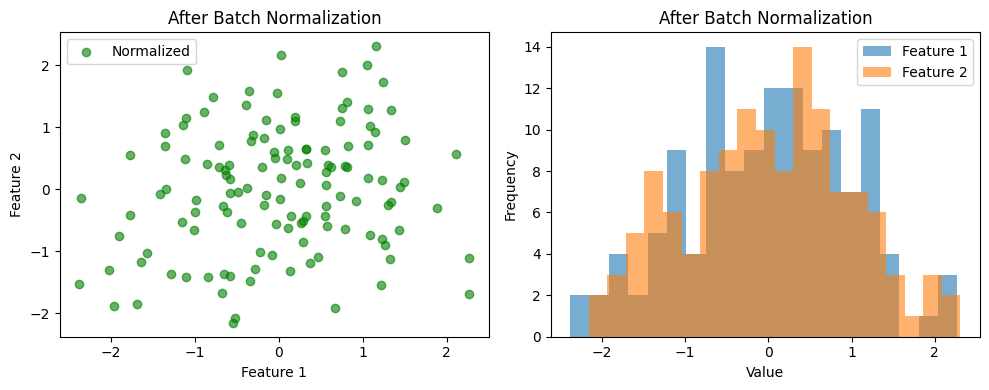

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot of normalized data
axs[0].scatter(X_bn[:, 0].detach(), X_bn[:, 1].detach(), c='green', alpha=0.6, label='Normalized')
axs[0].set_title('After Batch Normalization')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].legend()

# Histogram of each feature
axs[1].hist(X_bn[:, 0].detach().numpy(), bins=20, alpha=0.6, label='Feature 1')
axs[1].hist(X_bn[:, 1].detach().numpy(), bins=20, alpha=0.6, label='Feature 2')
axs[1].set_title('After Batch Normalization')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].legend()

plt.tight_layout()
plt.show()

## 5. Manual implementation

In this section, we re-implement **Batch Normalization (BN)** from scratch.
This helps illustrate what happens mathematically inside a `BatchNorm` layer.

We will:

1. Compute the batch-wise **mean** and **standard deviation**.
2. Normalise each feature.
3. Optionally apply **scaling (γ)** and **shifting (β)**.
4. Visualise and compare the results with the unnormalised data.

In [7]:
batch_size = 8
epsilon = 1e-5  # small constant to avoid division by zero

X_bn_manual = []

# Optional learnable parameters (usually initialized as γ=1 and β=0)
gamma = torch.ones(2)
beta = torch.zeros(2)

# Manual Batch Normalization
for i in range(0, len(X), batch_size):
    batch = X[i:i+batch_size]
    
    # 1. Compute mean and std per feature within the batch
    mean = batch.mean(dim=0)
    std = batch.std(dim=0, unbiased=False)
    
    # 2. Normalize: (x - mean) / sqrt(var + epsilon)
    x_hat = (batch - mean) / (std + epsilon)
    
    # 3. Scale and shift
    y = gamma * x_hat + beta
    
    X_bn_manual.append(y)

X_bn_manual = torch.cat(X_bn_manual, dim=0)

print("Feature means after manual BN:", X_bn_manual.mean(dim=0))
print("Feature stds after manual BN:", X_bn_manual.std(dim=0))

print("Manual means match torch.nn.BatchNorm?", torch.allclose(X_bn_manual.mean(dim=0), X_bn.mean(dim=0), atol=9))
print("Manual stds match torch.nn.BatchNorm?", torch.allclose(X_bn_manual.std(dim=0), X_bn.std(dim=0), atol=9))

Feature means after manual BN: tensor([-5.2154e-08,  5.5879e-08])
Feature stds after manual BN: tensor([1.0039, 1.0039])
Manual means match torch.nn.BatchNorm? True
Manual stds match torch.nn.BatchNorm? True


## Discussion

By comparing the datapoints in scatter and frequency histogram plots, we can see that:

* Before normalization, the features had very different means and variances.
* After Batch Normalization, each feature within a batch is centred around zero and scaled to have unit variance.

This process helps stabilise training in deep networks by keeping activations in a consistent range, leading to faster convergence and often better generalisation.

You can experiment further by:
- Modifying input values or adding new samples.  
- Applying BatchNorm in "training mode" to see how running statistics are updated.  
- Changing γ (scale) and β (shift) to see how the distributions move and stretch.
